# Regularizadores

- Neste código iremos analisar como funcionam os regularizadores e como eles são usados para evitar *overfitting*, fenônemo que faz com o modelo não generalize bem em outros dataset além do usando durante o treino.

# *Overfitting*

- Redes neurais são muito flexíveis porque não se limitam a ver cada atributo a ser aprendido individualmente. Em vez disso, elas podem aprender interações entre os atributos. Por causa disso, mesmo quando temos apenas um pequeno número de atributos, as redes neurais profundas são capazes de chegar ao *overfitting*, um cenário onde o modelo aprende a classificar muito bem (as vezes, perfeitamente) as instâncias de treino, porém não generaliza para outras instâncias não vista (como são os casos de amostras do conjunto de validação ou teste).

- Para evitar esse cenário, algumas técnicas foram propostas para evitar o *overfitting*.

**Como introduzido, nesta aula prática, implementaremos e testaremos duas técnicas para evitar o *overfitting*: *Dropout* e *Weight Decay***

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [ ]:
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import optim, nn

import numpy as np

import os
import sys
import time

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

print(device)

cpu


- Na célula abaixo, iremos definir funções auxiliares para o carregamento dos dados. Neste notebook, utilizaremos os dados do MNIST, visto em um notebook passado, e do Fashion-MNIST, uma base de dados com as mesmas características do MNIST original, porém as imagens são imagens de roupas, sapatos, etc.
    - **Apenas para relembrar:** os dados dos datasets possuem dimensão `1 x 28 x 28`, o conjunto de treino possui 60000 amostras, o conjunto de teste possui 10000 amostras e temos um problema de classificação com 10 classes.

In [ ]:
# código para carregar o dataset do MNIST
# http://yann.lecun.com/exdb/mnist/
def load_data_mnist(batch_size, num_workers=2):
    root = os.path.join('~', '.pytorch', 'datasets', 'mnist')
    root = os.path.expanduser(root)

    train_set = datasets.MNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
    test_set = datasets.MNIST(root=root, train=False, download=False, transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

# código para carregar o dataset do Fashion-MNIST
# https://github.com/zalandoresearch/fashion-mnist
def load_data_fashion_mnist(batch_size, num_workers=2):
    root=os.path.join('~', '.pytorch', 'datasets', 'fashion-mnist')
    root = os.path.expanduser(root)

    train_set = datasets.FashionMNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
    test_set = datasets.FashionMNIST(root=root, train=False, download=False, transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

- Na célula debaixo iremos definir algumas funções auxiliares para avaliar o nosso modelo (computar a acurácia) e realizar um processo de treino/validação dele.

In [ ]:
# Função usada para calcular acurácia
def evaluate_accuracy(dataloader, model, criterion):
    """Evaluate accuracy of a model on the given dataloader."""

    acc_sum = 0
    loss_sum = 0
    num_samples = 0

    with torch.no_grad(): # usaremos no_grad() para não acumular o gradiente nos pesos
        for X, y in dataloader:
            # Fazendo o casting para o dispositivo apropriado
            X = X.to(device)
            y = y.to(device)

            # Realizando o forward e computando a loss
            logits = model(X)
            loss_sum += criterion(logits, y).item()

            # Computando as predições propriamente ditas (qual classe que predizemos)
            probabilities = F.softmax(logits, dim=1)
            preds = torch.max(probabilities, dim=1)[1]

            # Atualizando a acurácia acumulada e o número total de samples
            acc_sum += (preds == y).sum().item()
            num_samples += y.size()[0]

    # Computando a média da acurácia e da loss
    average_acc = acc_sum / num_samples
    average_loss = loss_sum / len(dataloader)

    return average_acc, average_loss


# Função usada no treinamento e validação da rede
def train_validate(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    print('[info] training on', device)

    # Definindo listas para salvarmos as funções de perda (para plots futuros)
    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        num_samples = 0
        train_acc_sum = 0.0
        train_loss_sum = 0.0
        start = time.time()

        model.train()
        for X, y in train_loader:
            # Zerando os gradientes para que as derivadas não sejam acumuladas
            optimizer.zero_grad()

            # Fazendo o casting para o dispositivo apropriado
            X = X.to(device)
            y = y.to(device)

            # Realizando o forward e computando a loss
            logits = model(X)
            loss = criterion(logits, y)

            # Realizando o backpropagation pela rede (.backward() da loss + .step() do otimizador)
            loss.backward()
            optimizer.step()

            # Computando as predições propriamente ditas (qual classe que predizemos)
            probabilities = F.softmax(logits, dim=1)
            preds = torch.max(probabilities, dim=1)[1]

            # Atualizando os acumuladores para printar o desempenho da rede na época
            train_loss_sum += loss.item()
            train_acc_sum += (preds == y).sum().item()
            num_samples += y.size()[0]

        # Computando a média dos acumuladores
        train_acc = train_acc_sum / num_samples
        train_loss = train_loss_sum / len(train_loader)

        # Computando acurácia e loss para os dados de teste e exibindo o desempenho do modelo
        model.eval()
        test_acc, test_loss = evaluate_accuracy(test_loader, model, criterion)
        print(f'Epoch {epoch+1} => train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, ' + \
              f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f} , time: {(time.time() - start):.1f} sec')

        # Salvando as loss de treino e teste
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list


# Função para inicializar pesos da rede
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.01) # valores iniciais são uma normal
        m.bias.data.fill_(0)

## Conjunto de Exercícios 1. Dropout

- Dropout é uma das formas mais interessantes de regularizar sua rede neural. A ideia do Droupout é simples: durante o passo de `forward`, alguns neurônios são aleatoriamente "desligados", ou seja, são zerados, e não são utilizados em nenhum processamento. Em cada passo do `forward`, neurônios diferentes são "desligados" aleatoriamente, de acordo com uma probabilide pré-definida.
    - **Observação:** Lembre-se que esse processo só acontece durante o treino. Durante o teste, Droupout não tem nenhuma ação e todos os neurônios são usados para gerar o resultado final. Em PyTorch, conseguimos garantir esse efeito utilizando `model.train()` antes do treinamento (uma das coisas que ele faz é ativar o Droupout, se estiver presente na arquitetura), e `model.eval()` antes da avaliação (analogamente ao caso anterior, ele irá desativar o Droupout, se estiver presente na arquitetura).

- Formalmente, suponha um neurônio com ativação $h$ e um Droupout com probabilide $p$ (de zerar ou "desligar" o neurônio). Logo, essa técnica irá "desligar" a ativação desse neurônio com probabilidade $p$ ou reescala-la baseado na probabilidade dessa unidade de processamento permanecer ativa (isto é, $1-p$):

$$
\begin{aligned}
h_\text{novo} =
\begin{cases}
    0 & \text{ com probabilidade } p \\
    \frac{h}{1-p} & \text{ caso contrário}
\end{cases}
\end{aligned}
$$

- Tal método é interessante e chamou a atenção do mundo acadêmico por ser muito simples de implementar e poder impulsar significativamente o desempenho do modelo.

### Implementação

- Em frameworks atuais (como no MxNet, TensorFlow, e PyTorch), para utilizar os benefícios do Dropout basta adicionar a camada homônima (passando como argumento a probabilidade de desligamento dos neurônios) durante a construção da arquitetura.

- Durante o treino, a camada Droupout irá "desligar" aleatoriamente algumas saídas da camada anterior (ou equivalentemente, as entradas para a camada subsequente) de acordo com a probabilidade especificada.

In [ ]:
# Usaremos essa função para
def check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay):
    # Definido a nossa função de custo (entropia cruzada)
    # Lembre-se que na implementação do PyTorch não precisamos colocar uma SoftMax no final da nossa rede
    criterion = nn.CrossEntropyLoss()

    # Definido um otimizador (Gradiente Descendente Estocástico)
    # Aqui nós adicionamos um parâmetro de weight decay para implementar regularização L2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Realizando o treinamento e validação do modelo
    train_losses, test_losses = train_validate(model, train_loader, test_loader, optimizer, criterion, num_epochs)

    # Plotando curva da loss de treino e teste
    plt.figure(figsize=(10, 8))
    plt.title('Curva da Loss de treino e teste')
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.show()

In [ ]:
# parâmetros: learning rate (ou taxa de aprendizado), número de epochs e valor de weight decay
lr = 0.03
num_epochs = 20
weight_decay = 0 # por enquanto nós não trabalharemos com regularização L2, apenas Dropout

# Realizando o carregamento dos dados (Fashion-MNIST)
batch_size = 32
train_loader, test_loader = load_data_fashion_mnist(batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 22.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 333kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


[info] training on cpu
Epoch 1 => train loss: 1.3308, train acc: 0.4940, test loss: 0.7682, test acc: 0.7067 , time: 14.6 sec
Epoch 2 => train loss: 0.6162, train acc: 0.7801, test loss: 0.5711, test acc: 0.7939 , time: 15.6 sec
Epoch 3 => train loss: 0.5028, train acc: 0.8212, test loss: 0.4903, test acc: 0.8280 , time: 14.3 sec
Epoch 4 => train loss: 0.4399, train acc: 0.8421, test loss: 0.4404, test acc: 0.8436 , time: 14.8 sec
Epoch 5 => train loss: 0.4037, train acc: 0.8547, test loss: 0.4226, test acc: 0.8487 , time: 15.0 sec
Epoch 6 => train loss: 0.3791, train acc: 0.8624, test loss: 0.4098, test acc: 0.8531 , time: 14.4 sec
Epoch 7 => train loss: 0.3597, train acc: 0.8688, test loss: 0.3873, test acc: 0.8610 , time: 14.4 sec
Epoch 8 => train loss: 0.3433, train acc: 0.8753, test loss: 0.3726, test acc: 0.8674 , time: 16.1 sec
Epoch 9 => train loss: 0.3304, train acc: 0.8807, test loss: 0.3749, test acc: 0.8669 , time: 15.1 sec
Epoch 10 => train loss: 0.3196, train acc: 0.8833,

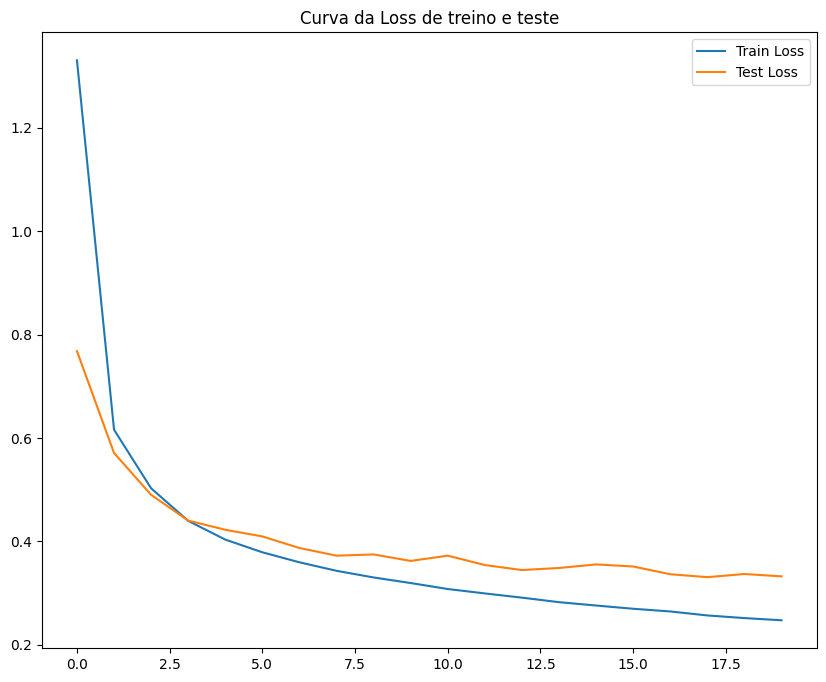

In [ ]:
# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Execute essa célula para ver o desempenho do modelo sem nenhuma regularização
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

[info] training on cpu
Epoch 1 => train loss: 1.3053, train acc: 0.5066, test loss: 0.7549, test acc: 0.7272 , time: 15.1 sec
Epoch 2 => train loss: 0.6447, train acc: 0.7696, test loss: 0.6452, test acc: 0.7547 , time: 14.6 sec
Epoch 3 => train loss: 0.5138, train acc: 0.8179, test loss: 0.5160, test acc: 0.8173 , time: 15.9 sec
Epoch 4 => train loss: 0.4507, train acc: 0.8381, test loss: 0.4502, test acc: 0.8404 , time: 15.0 sec
Epoch 5 => train loss: 0.4146, train acc: 0.8509, test loss: 0.4265, test acc: 0.8475 , time: 14.7 sec
Epoch 6 => train loss: 0.3866, train acc: 0.8603, test loss: 0.4316, test acc: 0.8479 , time: 14.9 sec
Epoch 7 => train loss: 0.3664, train acc: 0.8669, test loss: 0.3993, test acc: 0.8533 , time: 15.1 sec
Epoch 8 => train loss: 0.3508, train acc: 0.8712, test loss: 0.3870, test acc: 0.8595 , time: 16.4 sec
Epoch 9 => train loss: 0.3351, train acc: 0.8783, test loss: 0.4265, test acc: 0.8471 , time: 15.4 sec
Epoch 10 => train loss: 0.3241, train acc: 0.8818,

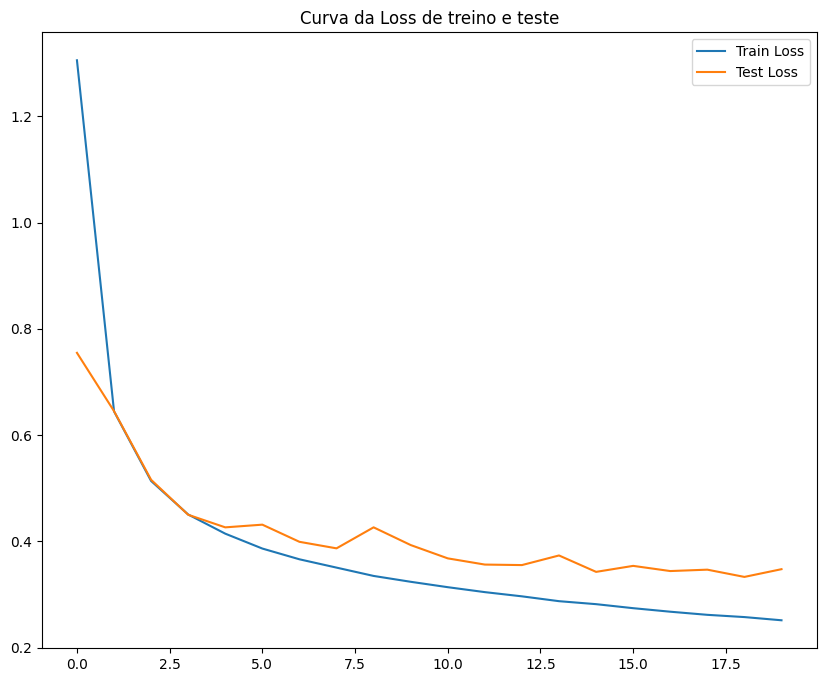

In [ ]:
# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Agora, modifique a rede anterior adicionando camadas de dropout entre camadas Linear e ReLU
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

## Conjunto de Exercícios 2. Weight Decay

- Weight Decay (comumente chamado regularização L2), é uma das técnicas mais utilizadas para regularizar modelos paramétricos de aprendizado de máquina. A intuição básica por trás do Weight Decay é a noção de que entre todas as funções $f$, a função $f=0$ é a mais simples. Intuitivamente, podemos medir funções pela sua proximidade a zero. Mas quão devemos medir a distância entre uma função e zero? Não há uma resposta correta. De fato, ramos inteiros da matemática são dedicados a responder a esta questão.

- Para nossos propósitos atuais, uma interpretação muito simples será suficiente: vamos considerar uma função linear $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ é simples se o seu vetor de peso $\mathbf{w}$ for pequeno. Podemos medir isso via norma $||\mathbf{w}||^2$. Uma maneira de manter o vetor de peso pequeno é adicionar sua norma como um termo de penalidade ao problema de minimizar a função de perda (ou *loss*). Assim, nós substituímos nosso objetivo original, *minimizar o erro de previsão nos rótulos de treinamento*, com novo objetivo, *minimizar o erro de previsão e o termo de penalidade*. Agora, se o vetor de peso se tornar muito grande, nosso algoritmo de aprendizagem vai encontrar mais lucro minimizando a norma $||\mathbf{w}||^2$ do que minimizando o erro de treinamento.

- Tecnicamente, para uma função de custo qualquer $\mathcal{L}$, a adição do novo termo de penalidade (ou *weight decay*) acontece da seguinte forma:

$$\mathcal{L}(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2$$

- Esse parâmetro não negativo $\lambda \geq 0$ dita a quantidade de regularização. Para $\lambda = 0$, recuperamos nossa função de perda original, enquanto para $\lambda > 0 $ garantimos que os pesos $\mathbf{w}$ não crescerão demais.

### Implementação

- Em frameworks atuais (como no MxNet, TensorFlow, e PyTorch), Weight Decay pode ser facilmente agregado à função de custo durante a construção do modelo ou na definição do otimizador, como no caso de PyTorch.

In [ ]:
# parâmetros: learning rate (ou taxa de aprendizado), número de epochs e valor de weight decay
lr = 0.03
num_epochs = 20
weight_decay = 0 # não modifique esse parâmetro ainda, queremos rodar a rede primeiro sem nenhuma regularização

# Realizando o carregamento dos dados (Fashion-MNIST)
batch_size = 32
train_loader, test_loader = load_data_fashion_mnist(batch_size)

[info] training on cpu
Epoch 1 => train loss: 1.3101, train acc: 0.5061, test loss: 0.7189, test acc: 0.7465 , time: 13.7 sec
Epoch 2 => train loss: 0.6100, train acc: 0.7828, test loss: 0.6454, test acc: 0.7583 , time: 14.0 sec
Epoch 3 => train loss: 0.5022, train acc: 0.8209, test loss: 0.5255, test acc: 0.8106 , time: 15.1 sec
Epoch 4 => train loss: 0.4420, train acc: 0.8413, test loss: 0.4652, test acc: 0.8290 , time: 14.3 sec
Epoch 5 => train loss: 0.4078, train acc: 0.8527, test loss: 0.4278, test acc: 0.8454 , time: 14.0 sec
Epoch 6 => train loss: 0.3845, train acc: 0.8607, test loss: 0.4067, test acc: 0.8536 , time: 14.0 sec
Epoch 7 => train loss: 0.3619, train acc: 0.8688, test loss: 0.4191, test acc: 0.8495 , time: 14.2 sec
Epoch 8 => train loss: 0.3467, train acc: 0.8747, test loss: 0.3734, test acc: 0.8657 , time: 14.0 sec
Epoch 9 => train loss: 0.3346, train acc: 0.8781, test loss: 0.3799, test acc: 0.8586 , time: 14.1 sec
Epoch 10 => train loss: 0.3211, train acc: 0.8822,

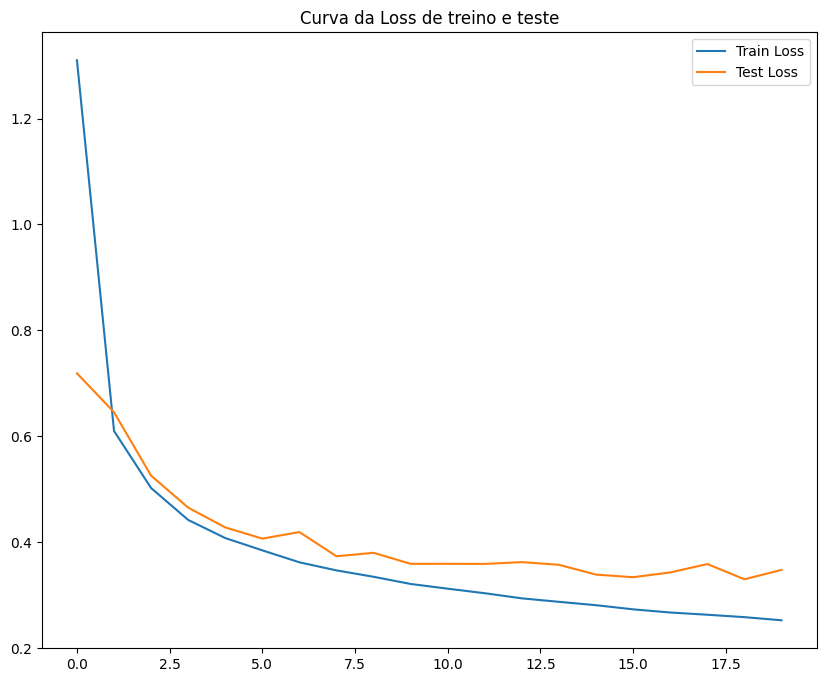

In [ ]:
# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Execute essa célula para ver o desempenho do modelo sem nenhuma regularização
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

[info] training on cpu
Epoch 1 => train loss: 1.3272, train acc: 0.4933, test loss: 0.8153, test acc: 0.6971 , time: 14.6 sec
Epoch 2 => train loss: 0.6276, train acc: 0.7768, test loss: 0.6027, test acc: 0.7868 , time: 14.3 sec
Epoch 3 => train loss: 0.5029, train acc: 0.8234, test loss: 0.4816, test acc: 0.8305 , time: 14.0 sec
Epoch 4 => train loss: 0.4423, train acc: 0.8410, test loss: 0.4696, test acc: 0.8335 , time: 14.0 sec
Epoch 5 => train loss: 0.4062, train acc: 0.8548, test loss: 0.4298, test acc: 0.8456 , time: 13.9 sec
Epoch 6 => train loss: 0.3813, train acc: 0.8631, test loss: 0.4190, test acc: 0.8487 , time: 14.1 sec
Epoch 7 => train loss: 0.3610, train acc: 0.8684, test loss: 0.4663, test acc: 0.8291 , time: 14.1 sec
Epoch 8 => train loss: 0.3453, train acc: 0.8749, test loss: 0.3784, test acc: 0.8651 , time: 15.1 sec
Epoch 9 => train loss: 0.3318, train acc: 0.8792, test loss: 0.3669, test acc: 0.8714 , time: 14.4 sec
Epoch 10 => train loss: 0.3203, train acc: 0.8829,

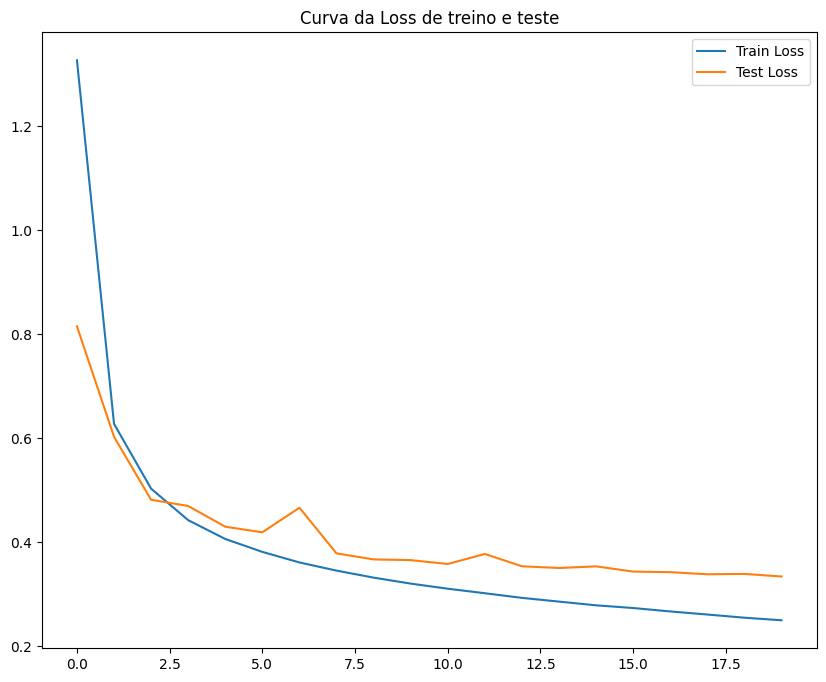

In [ ]:
weight_decay = 0 # agora modifique esse valor. Qual o impacto dele durante o treinamento?

# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

## Conjunto de Exercícios 3. MNIST - Overfitting e Regularizadores

- Agora usaremos um dataset específico juntamente com um rede mais profunda para tentar mostrar o efeito de *overfitting* e entender como as técnicas de regularização aprendidas podem ser usadas para resolver esse problema.

- O modelo implementado abaixo usa o dataset MNIST treinando uma rede com quatro camadas que não usa nenhum método de regularização. Note a diferença entre o *loss* e a acurácia de treino e teste. Um resultado onde o *loss* do teste é relativamente maior que o treino (caso do exemplo abaixo) indica que um (neste caso, princípio de) *overfitting* está acontecendo. Use as técnicas vistas nesta aula prática para tratar esse problema.

- Especificamente, implemente:
    1. Uma versão dessa arquitetura com Dropout. Teste diferentes valores de probabilidade de forma a diminuir o *overfitting*;
    2. Uma versão desse modelo com Weight Decay. Teste diferentes valores de $\lambda$ de forma a diminuir o *overfitting*;
    3. Uma versão que combina os dois métodos de regularização aprendidos. Talvez seja necessário testar diferentes valores para a probabilidade do Dropout e do $\lambda$.

In [ ]:
# parâmetros: learning rate (ou taxa de aprendizado), número de epochs e valor de weight decay
lr = 0.03
num_epochs = 20
weight_decay = 0 # não modifique esse parâmetro ainda, queremos rodar a rede primeiro sem nenhuma regularização

# Realizando o carregamento dos dados (MNIST)
batch_size = 32
train_loader, test_loader = load_data_mnist(batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 15.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 32.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]


[info] training on cpu
Epoch 1 => train loss: 1.6164, train acc: 0.4224, test loss: 0.5450, test acc: 0.8395 , time: 14.2 sec
Epoch 2 => train loss: 0.4075, train acc: 0.8817, test loss: 0.3119, test acc: 0.9092 , time: 13.9 sec
Epoch 3 => train loss: 0.2729, train acc: 0.9209, test loss: 0.2189, test acc: 0.9365 , time: 14.7 sec
Epoch 4 => train loss: 0.2003, train acc: 0.9423, test loss: 0.1648, test acc: 0.9521 , time: 14.6 sec
Epoch 5 => train loss: 0.1589, train acc: 0.9538, test loss: 0.1486, test acc: 0.9564 , time: 14.1 sec
Epoch 6 => train loss: 0.1307, train acc: 0.9622, test loss: 0.1316, test acc: 0.9619 , time: 14.1 sec
Epoch 7 => train loss: 0.1104, train acc: 0.9680, test loss: 0.1187, test acc: 0.9652 , time: 14.0 sec
Epoch 8 => train loss: 0.0945, train acc: 0.9725, test loss: 0.1072, test acc: 0.9695 , time: 13.8 sec
Epoch 9 => train loss: 0.0823, train acc: 0.9757, test loss: 0.1014, test acc: 0.9701 , time: 13.9 sec
Epoch 10 => train loss: 0.0730, train acc: 0.9790,

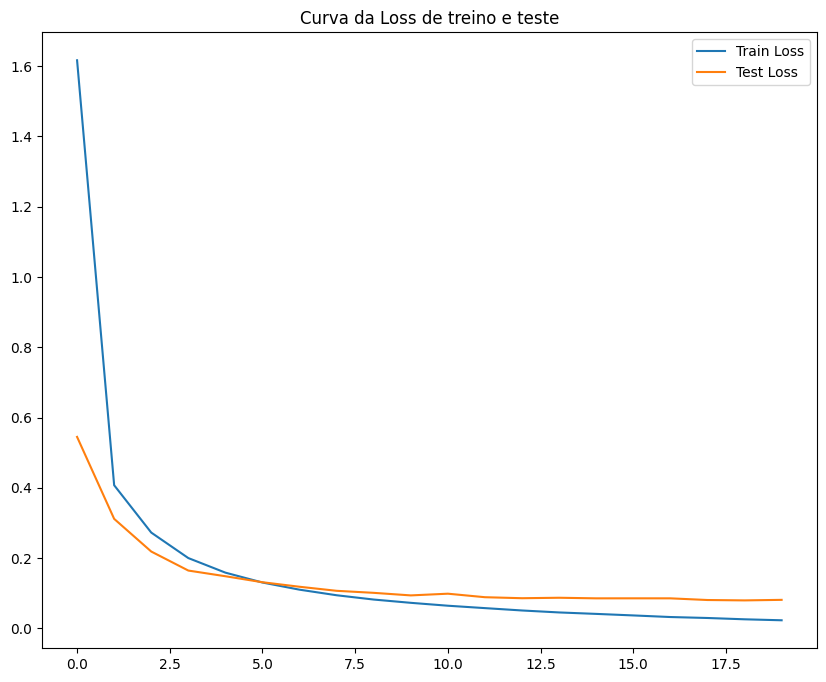

In [ ]:
# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Execute essa célula para ver o desempenho do modelo sem nenhuma regularização
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 128),               # camada densamente conectada
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

[info] training on cpu
Epoch 1 => train loss: 1.5840, train acc: 0.4380, test loss: 0.5530, test acc: 0.8388 , time: 14.6 sec
Epoch 2 => train loss: 0.4113, train acc: 0.8795, test loss: 0.3078, test acc: 0.9102 , time: 14.3 sec
Epoch 3 => train loss: 0.2688, train acc: 0.9219, test loss: 0.2178, test acc: 0.9362 , time: 13.8 sec
Epoch 4 => train loss: 0.1968, train acc: 0.9427, test loss: 0.1780, test acc: 0.9464 , time: 14.0 sec
Epoch 5 => train loss: 0.1547, train acc: 0.9552, test loss: 0.1413, test acc: 0.9564 , time: 13.9 sec
Epoch 6 => train loss: 0.1280, train acc: 0.9627, test loss: 0.1215, test acc: 0.9625 , time: 13.9 sec
Epoch 7 => train loss: 0.1071, train acc: 0.9682, test loss: 0.1084, test acc: 0.9678 , time: 13.9 sec
Epoch 8 => train loss: 0.0926, train acc: 0.9729, test loss: 0.1011, test acc: 0.9692 , time: 14.1 sec
Epoch 9 => train loss: 0.0808, train acc: 0.9760, test loss: 0.0957, test acc: 0.9711 , time: 14.0 sec
Epoch 10 => train loss: 0.0707, train acc: 0.9792,

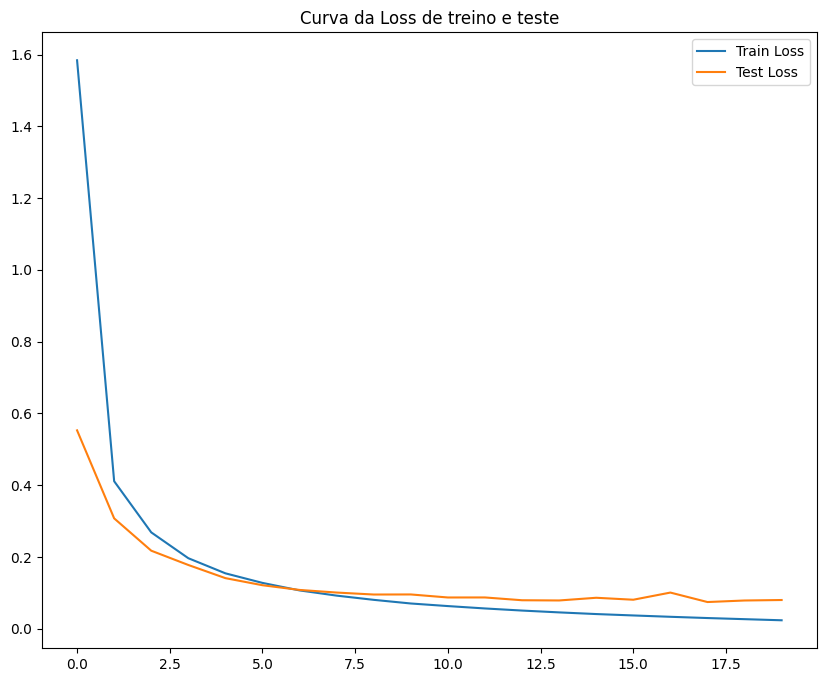

In [ ]:
weight_decay = 0 # agora modifique esse valor.

# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Além de weight decay, modifique a rede anterior adicionando camadas de dropout entre camadas Linear e ReLU
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

[info] training on cpu
Epoch 1 => train loss: 1.6345, train acc: 0.4082, test loss: 0.6220, test acc: 0.8018 , time: 16.0 sec
Epoch 2 => train loss: 0.4321, train acc: 0.8738, test loss: 0.3114, test acc: 0.9085 , time: 14.8 sec
Epoch 3 => train loss: 0.2794, train acc: 0.9201, test loss: 0.2306, test acc: 0.9327 , time: 14.6 sec
Epoch 4 => train loss: 0.2058, train acc: 0.9404, test loss: 0.1661, test acc: 0.9519 , time: 14.4 sec
Epoch 5 => train loss: 0.1619, train acc: 0.9526, test loss: 0.1420, test acc: 0.9589 , time: 14.5 sec
Epoch 6 => train loss: 0.1339, train acc: 0.9613, test loss: 0.1238, test acc: 0.9634 , time: 14.5 sec
Epoch 7 => train loss: 0.1141, train acc: 0.9667, test loss: 0.1140, test acc: 0.9646 , time: 14.7 sec
Epoch 8 => train loss: 0.0991, train acc: 0.9714, test loss: 0.1157, test acc: 0.9629 , time: 15.3 sec
Epoch 9 => train loss: 0.0895, train acc: 0.9741, test loss: 0.0972, test acc: 0.9706 , time: 14.7 sec
Epoch 10 => train loss: 0.0804, train acc: 0.9764,

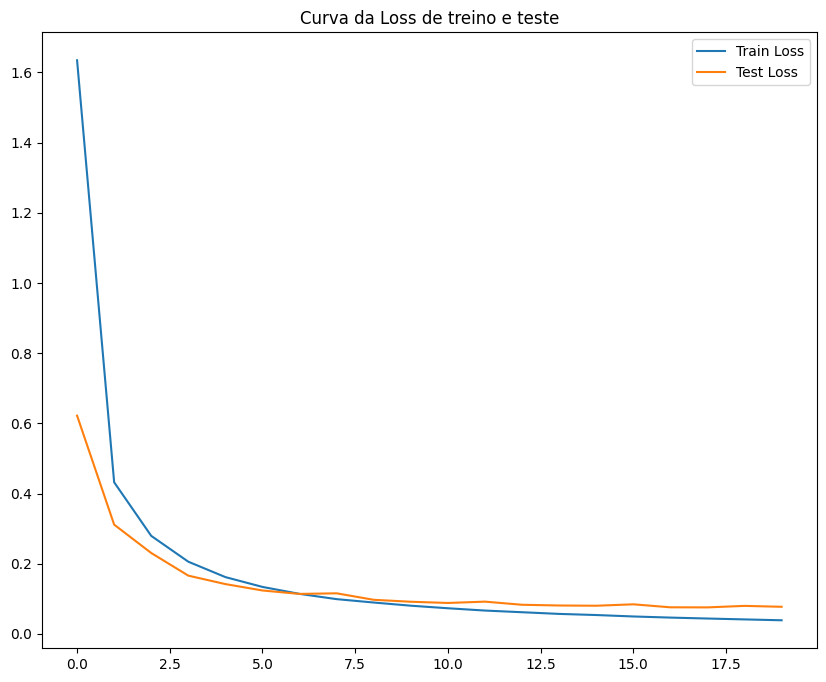

In [ ]:
weight_decay = 0.0005  # agora modifique esse valor.

# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Além de weight decay, modifique a rede anterior adicionando camadas de dropout entre camadas Linear e ReLU
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

[info] training on cpu
Epoch 1 => train loss: 1.5969, train acc: 0.4227, test loss: 0.5206, test acc: 0.8422 , time: 14.9 sec
Epoch 2 => train loss: 0.3908, train acc: 0.8874, test loss: 0.2982, test acc: 0.9080 , time: 15.1 sec
Epoch 3 => train loss: 0.2622, train acc: 0.9237, test loss: 0.2093, test acc: 0.9389 , time: 14.4 sec
Epoch 4 => train loss: 0.1944, train acc: 0.9439, test loss: 0.1704, test acc: 0.9494 , time: 14.3 sec
Epoch 5 => train loss: 0.1549, train acc: 0.9549, test loss: 0.1368, test acc: 0.9594 , time: 14.6 sec
Epoch 6 => train loss: 0.1288, train acc: 0.9630, test loss: 0.1198, test acc: 0.9661 , time: 15.0 sec
Epoch 7 => train loss: 0.1101, train acc: 0.9679, test loss: 0.1107, test acc: 0.9680 , time: 15.6 sec
Epoch 8 => train loss: 0.0947, train acc: 0.9727, test loss: 0.1034, test acc: 0.9676 , time: 15.4 sec
Epoch 9 => train loss: 0.0834, train acc: 0.9757, test loss: 0.0946, test acc: 0.9716 , time: 14.5 sec
Epoch 10 => train loss: 0.0738, train acc: 0.9787,

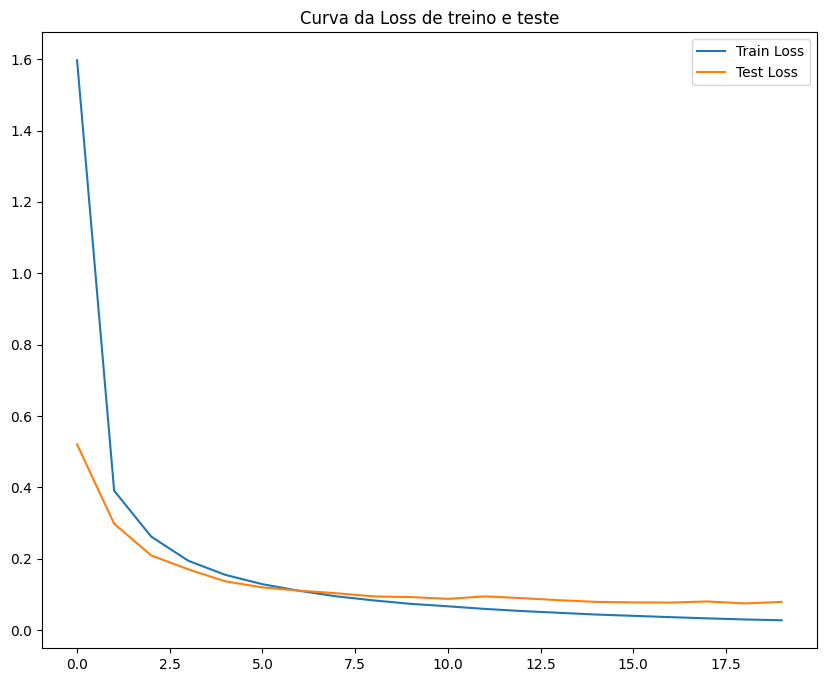

In [ ]:
weight_decay = 0.0001 # agora modifique esse valor.

# Rede simples somente com camadas densamente conectadas e função de ativação ReLU entre elas
# Além de weight decay, modifique a rede anterior adicionando camadas de dropout entre camadas Linear e ReLU
model = nn.Sequential(
    nn.Flatten(),                      # camada para realizar um flatten da imagem de entrada
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)                 # camada densamente conectada para classificação
)

model.apply(weights_init) # inicializando os pesos da nossa rede através da função auxiliar
model.to(device) # diz para a rede que ela deve ser treinada na GPU

check_model_performance(model, train_loader, test_loader, lr, num_epochs, batch_size, weight_decay)

## Exercícios

1. **Qual impacto de alterar a probabilidade da camada de *Dropout*?  Como fica uma rede com probabilidade de 50% de "desligar" os neurônios?**
  
  O Dropout é uma técnica de regularização utilizada para evitar o ajuste excessivo em redes neurais, pois elimina aleatoriamente neurônios durante o treinamento, impedindo que a rede se torne excessivamente dependente de unidades específicas. Esse processo força a rede a treinar múltiplas sub-redes diferentes a cada iteração, o que melhora sua capacidade de generalização ao simular um comportamento semelhante a um ensemble. Além disso, o Dropout reduz a co-adaptação entre neurônios, encorajando cada unidade a operar de forma mais independente, o que fortalece a habilidade da rede de aprender representações mais robustas e relevantes dos dados.

  Quando utilizamos uma probabilidade de 50% para o Dropout em uma camada oculta de uma rede neural, isso significa que, a cada iteração de treinamento, metade dos neurônios dessa camada são desligados aleatoriamente — ou seja, suas ativações são zeradas, e suas conexões temporariamente removidas da rede. Esse processo impede que a rede dependa demais de neurônios específicos, forçando os demais a assumirem maior responsabilidade pela predição. Como diferentes subconjuntos de neurônios são ativados a cada passo, o modelo acaba treinando como se fosse um conjunto de redes menores (sub-redes), o que melhora a capacidade de generalização e reduz o risco de overfitting. Para manter a escala das ativações consistente, os neurônios que permanecem ativos têm suas saídas amplificadas por um fator 1/p, ou seja, multiplicadas por 2 nesse caso. Durante a fase de teste, todos os neurônios são utilizados normalmente, sem desligamentos, pois os ajustes nos pesos e ativações já foram calibrados durante o treinamento com dropout invertido.


  2. **E em relação ao valor de $\lambda$ para o *Weight Decay*, qual impacto? Teste valores como 0.0005 e 0.0001.**

  O valor de
  𝜆
  λ no Weight Decay (ou regularização L2) controla a intensidade com que os pesos da rede neural são penalizados por serem grandes. Quando
  𝜆
  λ é muito pequeno, a penalização é quase inexistente, permitindo que os pesos cresçam livremente — o que pode levar ao overfitting, já que o modelo pode se ajustar demais aos dados de treino. Por outro lado, um
  𝜆
  λ muito grande força os pesos a permanecerem muito próximos de zero, o que simplifica excessivamente o modelo e pode causar underfitting, reduzindo sua capacidade de aprender padrões relevantes dos dados. Assim,
  𝜆
  λ atua como um hiperparâmetro de equilíbrio: ele deve ser cuidadosamente ajustado para garantir que o modelo seja suficientemente expressivo, mas sem se tornar complexo demais. Idealmente, o valor de
  𝜆
  λ é escolhido com base em validação cruzada, buscando o ponto de melhor desempenho fora da amostra de treino

  Os valores de
  𝜆
  λ para o Weight Decay influenciam diretamente o equilíbrio entre a capacidade de aprendizado e a generalização do modelo. Ao testar valores como 0.0001 e 0.0005, observa-se que ambos ajudam a reduzir o risco de overfitting em comparação com o caso sem regularização. Com
  𝜆
  =
  0.0001
  λ=0.0001, a penalização é sutil, permitindo que a rede ainda aprenda com bastante liberdade, mas já promovendo uma leve estabilização na loss de teste. Já com
  𝜆
  =
  0.0005
  λ=0.0005, a regularização atua com mais força, reduzindo a complexidade dos pesos e mantendo a diferença entre treino e teste ainda menor — o que indica uma generalização mais eficiente. Em ambos os casos, o modelo preserva sua capacidade de aprendizagem sem sofrer underfitting, sugerindo que esses valores de
  𝜆
  λ são eficazes para controlar a variância sem comprometer o desempenho.


3. ***Qual efeito da quantidade de *epochs* na acurácia final do modelo?***

  A quantidade de epochs tem um papel crucial na acurácia final do modelo, pois define quantas vezes a rede irá percorrer todo o conjunto de dados de treinamento para ajustar seus pesos. Em geral, nas primeiras epochs, o modelo aprende rapidamente e a acurácia aumenta significativamente; com o passar das epochs, os ganhos se tornam menores até estabilizarem. Se o número de epochs for muito baixo, o modelo pode não ter tempo suficiente para aprender padrões relevantes dos dados, resultando em underfitting. Por outro lado, um número muito alto de epochs pode levar ao overfitting, em que o modelo se ajusta demais aos dados de treino, prejudicando sua capacidade de generalização. O ideal é encontrar um ponto de equilíbrio — geralmente identificado com validação cruzada ou usando técnicas como early stopping — onde a acurácia de validação atinge seu pico sem deteriorar.



In [ ]:
print('teste')

teste
